1610612762


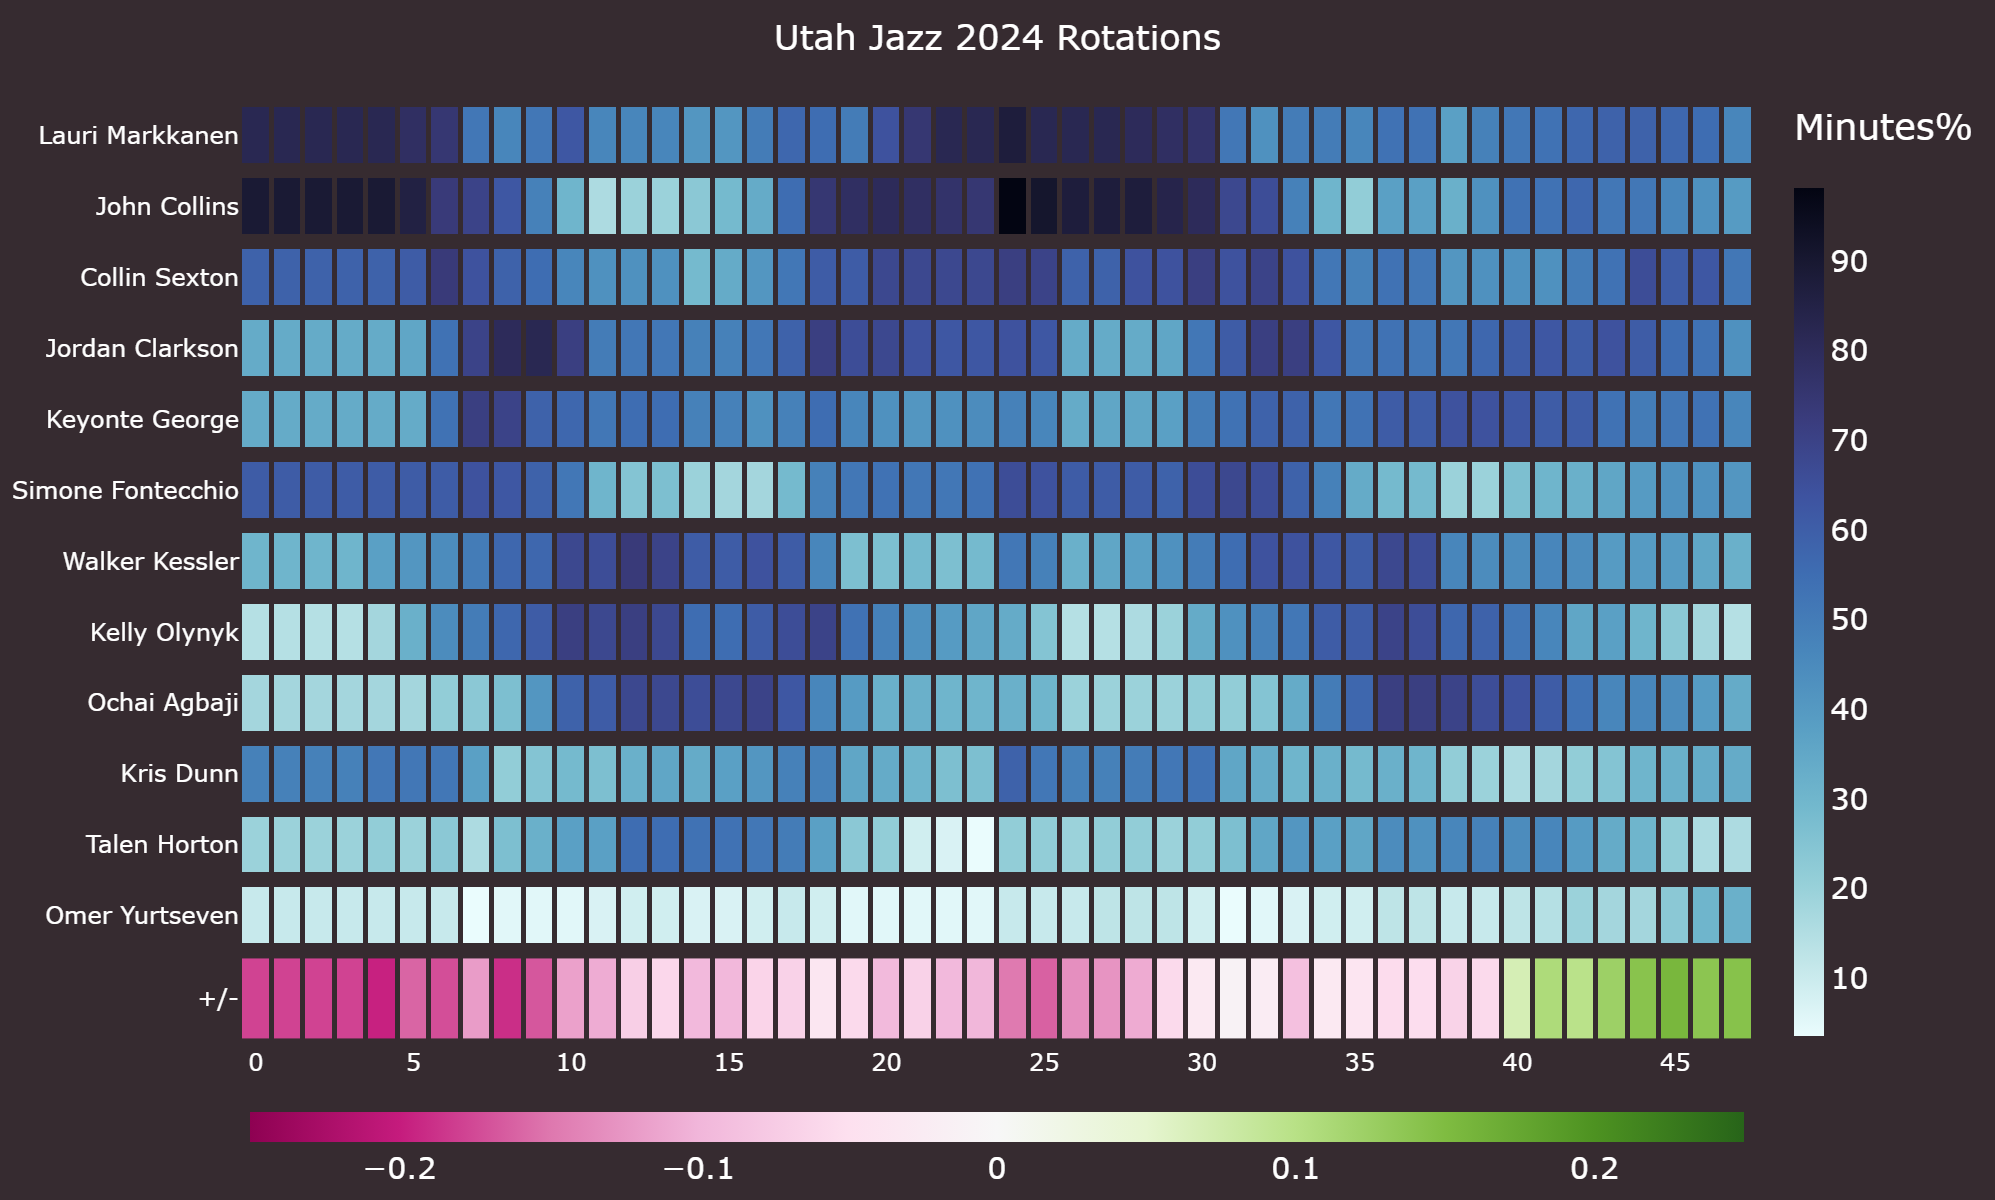

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from nba_api.stats.static import players,teams
import plotly.graph_objects as go
import time
from plotly.subplots import make_subplots

'''
def update_matrices(row):

    player = row['Player']
    start_minute = row['start']
    end_minute = row['end']
    plus_minus = row['PT_DIFF']

    # Increment the matrix based on player on-court times
    minutes_played_matrix.loc[player, start_minute:end_minute] += 1

    # Increment the plus_minus_matrix based on player on-court times
    plus_minus_matrix.loc[player, start_minute:end_minute] += plus_minus
'''

def convert_date(year,date):
    
    month,day = date.split('/')
    month = int(month)
    day = int(day)
    
    if month >8:
        year-=1
    game_date = int(year)*10000 + month*100+day
    return game_date
def graph_srotation(team,year,ps=False,start_date='',end_date = ''):
    carry = ''
    if ps ==True:
        carry='ps '
    
    team = team.upper()

    nba_teams = teams.get_teams()
    team_list= {}
    full_name = {}
    for org in nba_teams:
        team_list[org['abbreviation']] = org['id']
        full_name[org['abbreviation']] = org['full_name']
    
    

    team_id = team_list[team]
    print(team_id)

    url='https://raw.githubusercontent.com/gabriel1200/shot_data/master/rotations/'+str(year)+carry+'/'+str(team_id)+'.csv'
    #print(url)
    title = full_name[team]+ ' '+str(year)+ ' '+carry.upper() +'Rotations'
    df = pd.read_csv(url)
    # Convert the times to seconds
    df['start'] = df['IN_TIME_REAL']
    df['end'] = df['OUT_TIME_REAL']
    df['Player'] = df['PLAYER_FIRST']+' '+df['PLAYER_LAST'].str.split('-').str[0]
    df['start'] /=600
    df['end']/=600
    #print(df['end'].max())
    #print(df['start'].min())
    #df =df.drop_duplicates()


    #print(len(df))
    
    if start_date!='' or end_date!='':
        title =  title+'<br>'
        fields=['GAME_ID','GAME_DATE']
        shot_url = 'https://raw.githubusercontent.com/gabriel1200/shot_data/master/team/'+str(year)+carry+'/'+str(team_id)+'.csv'
        shotmap = pd.read_csv(shot_url,usecols=fields)
        shotmap = shotmap.drop_duplicates()
        games = shotmap.sort_values(by='GAME_DATE').reset_index(drop=True)
        if start_date !='':
            start_index = convert_date(year,start_date)
            title = title+ 'From: '+start_date
        if end_date !='':
            end_index = convert_date(year, end_date)
            title = title+' To '+end_date
        if start_date =='':
            start_index = games.iloc[0]['GAME_DATE']
        if end_date =='':
            end_index = games.iloc[-1]['GAME_DATE']
            
        games = games[(games.GAME_DATE<=end_index) &(games.GAME_DATE>=start_index)]
        
        game_range = games.GAME_ID.tolist()
        
        df = df[df.GAME_ID.isin(game_range)]
        
    maxgp = len(df.GAME_ID.unique())
    #print(gp)
    game_count =df.drop_duplicates(subset=['GAME_ID','PERSON_ID','Player'])
    
    player_count = game_count.groupby('PERSON_ID').count()[['GAME_ID']].reset_index()
    player_count.columns = ['PERSON_ID','GP']
    player_dict = dict(zip(player_count['PERSON_ID'], player_count['GP']))

    max_end_minute =int( df['end'].max())
    #print(int( df['start'].min()))
    #max_end_minute=48
    players = df['Player'].unique()
    
    # Use pd.cut to create intervals and groupby to perform the summation

    # Print or use the result as needed
    #print(test_matrix)
    # Create an empty matrix to represent player minutes played

    #start_time1 = time.time()
    step = 1
    
    minutes_played_matrix=  pd.DataFrame(index=players, columns=[i for i in range(0,max_end_minute,step)], data=float(0))
    
    #plus_minus_matrix=  pd.DataFrame(index=players, columns=[i for i in range(max_end_minute + 1)], data=0)


    plus_minus_matrix=  pd.DataFrame(index=players, columns=[i for i in range(0,max_end_minute,step)], data=float(0))
    #df['interval'] = df.apply(lambda row: pd.Interval(row['start'], row['end'], closed='right'), axis=1)
    #df.apply(update_matrices, axis=1)
    #print(minutes_played_matrix)
    #end_time1 = time.time()

    #df['interval'] = df.apply(lambda row: pd.interval_range(row['start'], row['end'], freq=1), axis=1)

    # Increment the matrix based on player on-court times
    #minutes_played_matrix = df.groupby(['Player', 'interval']).size().unstack(fill_value=0).cumsum(axis=1)

    # Increment the plus_minus_matrix based on player on-court times
    #plus_minus_matrix = df.groupby(['Player', 'interval'])['PT_DIFF'].sum().unstack(fill_value=0).cumsum(axis=1)
    #print(minutes_played_matrix)


    # Increment the matrix based on player on-court times
    #print(player_dict)
    for _, row in df.iterrows():
        pid = row['PERSON_ID']
        player = row['Player']
        start_minute = row['start']
        end_minute = row['end']+1
        plus_minus = row['PT_DIFF']
        gp =player_dict[pid]

        minutes_played_matrix.loc[player, start_minute:end_minute] += 1
        value = plus_minus
        if end_minute>start_minute:
            value =(plus_minus/(end_minute-start_minute))
        elif start_minute==end_minute:
            value=0
        plus_minus_matrix.loc[player, start_minute:end_minute] += float(value)
    '''
    print(plus_minus_matrix.iloc[2])
    print(plus_minus_matrix.iloc[2][0:20])

    print(plus_minus_matrix.iloc[2].sum())
    print(plus_minus_matrix.iloc[3])
    print(plus_minus_matrix.iloc[3].sum())
    print(plus_minus_matrix.iloc[4])
    print(plus_minus_matrix.iloc[4].sum())
    print(plus_minus_matrix.iloc[5])
    print(plus_minus_matrix.iloc[5].sum())
    '''

    minutes_played_matrix['total']= minutes_played_matrix.iloc[:].sum(axis=1)
    minutes_played_matrix.sort_values(by='total',inplace=True,ascending=True)
    minutes_played_matrix = minutes_played_matrix.tail(12)

    minutes_played_matrix = minutes_played_matrix[[i for i in range(0,48,step)]]
    #plus_minus_matrix = plus_minus_matrix[[i for i in range(0,48,step)]]
    
    



    total_plus = plus_minus_matrix.sum()

    total_plus/=5

    total_plus/=maxgp
    #print(total_plus)
    #print(total_plus.sum())

    
    total_plus = total_plus.reset_index(drop=True)
    
    
    data= []
    for val in total_plus:
        data.append(val)

    pmdata = [data[0:48]]
    
    #print(pmdata)
 

    #plus_row = pd.DataFrame(index=['+/-'], columns=total_plus.index.tolist(), data=total_plus.values.tolist())
    #minutes_played_matrix=minutes_played_matrix[minutes_played_matrix['total']>300]
    
    #print(plus_minus_matrix)
    #print(minutes_played_matrix['total'])
    #minutes_played_matrix.drop(columns='total',inplace=True)
    
    #print(plus_minus_matrix.iloc[0].sum())

    # Create the heatmap
    #minutes_played_matrix.sort_index(axis=22,inplace=True)\
    #print(maxgp)

    minutes_played_matrix[ minutes_played_matrix>maxgp]=maxgp
    minutes_played_matrix/=maxgp
    minutes_played_matrix*=100

    fig = make_subplots(rows=2,cols=1,row_heights=[0.9, 0.1],shared_yaxes=True,shared_xaxes=True,vertical_spacing=0)
    fig.add_trace(go.Heatmap(z=minutes_played_matrix.values,
                                    x=minutes_played_matrix.columns,
                                    y=minutes_played_matrix.index,
                                     name = 'data',
                                     zmax=maxgp,
                                     zmin=maxgp,
                                    xgap=5,
                                    ygap=15,
                                    type='heatmap',
                                    colorscale='ice_r',
                                     colorbar=dict(
                title="Minutes%<br><sup>&nbsp;</sup>")


            ),row=1,col=1)
    fig.add_trace(go.Heatmap(z=pmdata,
                                    x=minutes_played_matrix.columns,
                                    y=['+/-'],
                                    xgap=5,
                                    ygap=15,
                                     zmin=-.25,
                                    zmax=.25,
                                     name='data2',
                                    type='heatmap',
                                    colorscale='PiYg',
                             colorbar = dict(y=-.15,
                                             dtick=.1,
                                             titlefont=dict(
  size=10),
                                  
                                             
                                      
                                     orientation='h',),
                             


            ),row=2,col=1)
    fig.update_yaxes(tickfont=dict(color='white',size = 24),showgrid=False,zeroline=False)
    fig.update_xaxes(tickfont=dict(color='white',size = 24),showgrid=False,zeroline=False)
    # Customize the layout
    fig.update_layout(title=title,
                      titlefont = dict(size=35),
                      title_x=.5,
                          plot_bgcolor='#362b30',
                          paper_bgcolor='#362b30',
                      width=1800,
                      height=1200,
                      font=dict(color='white',size = 30),
                      
                      )
    #del minutes_played_matrix
    # Show the plot
    del minutes_played_matrix
    del plus_minus_matrix
    return fig

ps = False
fig = graph_srotation('uta',2024,ps=ps)
fig.show()



In [2]:
def player_rotation(player, year,ps=False,start_date='',end_date = ''):
    carry = ''
    if ps ==True:
        carry='ps'

    team = team.upper()

    nba_teams = teams.get_teams()
    team_list= {}
    full_name = {}
    for org in nba_teams:
        team_list[org['abbreviation']] = org['id']
        full_name[org['abbreviation']] = org['full_name']
    
    

    team_id = team_list[team]


    url='https://raw.githubusercontent.com/gabriel1200/shot_data/master/rotations/'+str(year)+carry+'/'+str(team_id)+'.csv'
    #print(url)
    title = full_name[team]+ ' '+str(year)+ ' '+carry.upper()
    df = pd.read_csv(url)
    # Convert the times to seconds
    df['start'] = df['IN_TIME_REAL']
    df['end'] = df['OUT_TIME_REAL']
    df['Player'] = df['PLAYER_FIRST']+' '+df['PLAYER_LAST'].str.split('-').str[0]
    df['start'] /=600
    df['end']/=600
    #print(df['end'].max())
    #print(df['start'].min())
    #df =df.drop_duplicates()


    #print(len(df))
    
    if start_date!='' or end_date!='':
        title =  title+'<br>'
        fields=['GAME_ID','GAME_DATE']
        shot_url = 'https://raw.githubusercontent.com/gabriel1200/shot_data/master/team/'+str(year)+carry+'/'+str(team_id)+'.csv'
        shotmap = pd.read_csv(shot_url,usecols=fields)
        shotmap = shotmap.drop_duplicates()
        games = shotmap.sort_values(by='GAME_DATE').reset_index(drop=True)
        if start_date !='':
            start_index = convert_date(year,start_date)
            title = title+ 'From: '+start_date
        if end_date !='':
            end_index = convert_date(year, end_date)
            title = title+' To '+end_date
        if start_date =='':
            start_index = games.iloc[0]['GAME_DATE']
        if end_date =='':
            end_index = games.iloc[-1]['GAME_DATE']
            
        games = games[(games.GAME_DATE<=end_index) &(games.GAME_DATE>=start_index)]
        
        game_range = games.GAME_ID.tolist()
        
        df = df[df.GAME_ID.isin(game_range)]
        
    maxgp = len(df.GAME_ID.unique())
    #print(gp)
    game_count =df.drop_duplicates(subset=['GAME_ID','PERSON_ID','Player'])
    
    player_count = game_count.groupby('PERSON_ID').count()[['GAME_ID']].reset_index()
    player_count.columns = ['PERSON_ID','GP']
    player_dict = dict(zip(player_count['PERSON_ID'], player_count['GP']))

    max_end_minute =int( df['end'].max())
    #print(int( df['start'].min()))
    #max_end_minute=48
    players = df['Player'].unique()
    
    # Use pd.cut to create intervals and groupby to perform the summation

    # Print or use the result as needed
    #print(test_matrix)
    # Create an empty matrix to represent player minutes played

    #start_time1 = time.time()
    step = 1
    
    minutes_played_matrix=  pd.DataFrame(index=players, columns=[i for i in range(0,max_end_minute,step)], data=float(0))
    
    #plus_minus_matrix=  pd.DataFrame(index=players, columns=[i for i in range(max_end_minute + 1)], data=0)


    plus_minus_matrix=  pd.DataFrame(index=players, columns=[i for i in range(0,max_end_minute,step)], data=float(0))
    #df['interval'] = df.apply(lambda row: pd.Interval(row['start'], row['end'], closed='right'), axis=1)
    #df.apply(update_matrices, axis=1)
    #print(minutes_played_matrix)
    #end_time1 = time.time()

    #df['interval'] = df.apply(lambda row: pd.interval_range(row['start'], row['end'], freq=1), axis=1)

    # Increment the matrix based on player on-court times
    #minutes_played_matrix = df.groupby(['Player', 'interval']).size().unstack(fill_value=0).cumsum(axis=1)

    # Increment the plus_minus_matrix based on player on-court times
    #plus_minus_matrix = df.groupby(['Player', 'interval'])['PT_DIFF'].sum().unstack(fill_value=0).cumsum(axis=1)
    #print(minutes_played_matrix)


    # Increment the matrix based on player on-court times
    #print(player_dict)
    for _, row in df.iterrows():
        pid = row['PERSON_ID']
        player = row['Player']
        start_minute = row['start']
        end_minute = row['end']+1
        plus_minus = row['PT_DIFF']
        gp =player_dict[pid]

        minutes_played_matrix.loc[player, start_minute:end_minute] += 1
        value = plus_minus
        if end_minute>start_minute:
            value =(plus_minus/(end_minute-start_minute))
        elif start_minute==end_minute:
            value=0
        plus_minus_matrix.loc[player, start_minute:end_minute] += float(value)
    '''
    print(plus_minus_matrix.iloc[2])
    print(plus_minus_matrix.iloc[2][0:20])

    print(plus_minus_matrix.iloc[2].sum())
    print(plus_minus_matrix.iloc[3])
    print(plus_minus_matrix.iloc[3].sum())
    print(plus_minus_matrix.iloc[4])
    print(plus_minus_matrix.iloc[4].sum())
    print(plus_minus_matrix.iloc[5])
    print(plus_minus_matrix.iloc[5].sum())
    '''

    minutes_played_matrix['total']= minutes_played_matrix.iloc[:].sum(axis=1)
    minutes_played_matrix.sort_values(by='total',inplace=True,ascending=True)
    minutes_played_matrix = minutes_played_matrix.tail(12)

    minutes_played_matrix = minutes_played_matrix[[i for i in range(0,48,step)]]
    #plus_minus_matrix = plus_minus_matrix[[i for i in range(0,48,step)]]
    
    



    total_plus = plus_minus_matrix.sum()

    total_plus/=5

    total_plus/=gp
    #print(total_plus)
    #print(total_plus.sum())

    
    total_plus = total_plus.reset_index(drop=True)
    
    
    data= []
    for val in total_plus:
        data.append(val)

    pmdata = [data[0:48]]
    
    #print(pmdata)
 

    #plus_row = pd.DataFrame(index=['+/-'], columns=total_plus.index.tolist(), data=total_plus.values.tolist())
    #minutes_played_matrix=minutes_played_matrix[minutes_played_matrix['total']>300]
    
    #print(plus_minus_matrix)
    #print(minutes_played_matrix['total'])
    #minutes_played_matrix.drop(columns='total',inplace=True)
    
    #print(plus_minus_matrix.iloc[0].sum())

    # Create the heatmap
    #minutes_played_matrix.sort_index(axis=22,inplace=True)

    #print(minutes_played_matrix)

    fig = make_subplots(rows=2,cols=1,row_heights=[0.9, 0.1],shared_yaxes=True,shared_xaxes=True,vertical_spacing=0)
    fig.add_trace(go.Heatmap(z=minutes_played_matrix.values,
                                    x=minutes_played_matrix.columns,
                                    y=minutes_played_matrix.index,
                                     name = 'data',
                                    xgap=10,
                                    ygap=15,
                                    type='heatmap',
                                    colorscale='Reds',
                                     colorbar=dict(
                title="Games<br>")


            ),row=1,col=1)
    fig.add_trace(go.Heatmap(z=pmdata,
                                    x=minutes_played_matrix.columns,
                                    y=['+/-'],
                                    xgap=10,
                                    ygap=15,
                                     zmin=-.3,
                                    zmax=.3,
                                     name='data2',
                                    type='heatmap',
                                    colorscale='PiYg',
                             colorbar = dict(y=-.15,
                                             dtick=.1,
                                  
                                             
                                      
                                     orientation='h',),
                             


            ),row=2,col=1)
    fig.update_yaxes(tickfont=dict(color='white',size = 24),showgrid=False,zeroline=False)
    fig.update_xaxes(tickfont=dict(color='white',size = 24),showgrid=False,zeroline=False)
    # Customize the layout
    fig.update_layout(title=title,
                      titlefont = dict(size=35),
                      title_x=.5,
                          plot_bgcolor='#161415',
                          paper_bgcolor='#211a1d',

                      width=1800,
                      height=1200,
                      font=dict(color='white',size = 30),
                      
                      )
    #del minutes_played_matrix
    # Show the plot
    del minutes_played_matrix
    del plus_minus_matrix
    return fig

    Minute  PT_DIFF
0        0  13345.0
1        1  13345.0
2        2  13345.0
3        3  13345.0
4        4  13345.0
5        5  13345.0
6        6  13345.0
7        7  13345.0
8        8  13345.0
9        9  13345.0
10      10  13345.0
11      11  13345.0
12      12  13345.0
13      13  13345.0
14      14  13345.0
15      15  13345.0
16      16  13345.0
17      17  13345.0
18      18  13345.0
19      19  13345.0
20      20  13345.0
21      21  13345.0
22      22  13345.0
23      23  13345.0
24      24  13345.0
25      25  13345.0
26      26  13345.0
27      27  13345.0
28      28  13345.0
29      29  13345.0
30      30  13345.0
31      31  13345.0
32      32  13345.0
33      33  13345.0
34      34  13345.0
35      35  13345.0
36      36  13345.0
37      37  13345.0
38      38  13345.0
39      39  13345.0
40      40  13345.0
41      41  13345.0
42      42  13345.0
43      43  13345.0
44      44  13345.0
45      45  13345.0
46      46  13345.0
47      47  13345.0
48      48   -380.0


In [3]:


# Creating a DataFrame
df = pd.read_csv('https://raw.githubusercontent.com/gabriel1200/shot_data/master/rotations/2019/1610612744.csv')

df['start'] = df['IN_TIME_REAL']
df['end'] = df['OUT_TIME_REAL']
df['Player'] = df['PLAYER_FIRST']+' '+df['PLAYER_LAST'].str.split('-').str[0]
df['start'] /=60
df['end']/=60
df['start'] =df['start'].astype(int)
df['start'] =df['end'].astype(int)

# Create a time grid for each minute in the game
print(int(df['end'].max()))
time_grid = pd.DataFrame({'Time': range(0, int(df['end'].max()), 10)})
time_grid['Time'] = time_grid['Time'].astype(int)
time_grid = time_grid.sort_values(by='Time')
df.sort_values(by='start',inplace=True)
#print(time_grid)
# Merge the time grid with the original data to associate point differentials
merged_df = pd.merge_asof(time_grid, df, left_on='Time', right_on='start', direction='backward')

# Calculate the duration in minutes for each time grid entry
merged_df['Duration'] = 0

# Calculate the point differential per minute
merged_df['+/- per Minute'] = merged_df['PT_DIFF'] / merged_df['Duration']
print(merged_df)
# Calculate the team's average +/- per minute for each 1-minute span
average_plus_minus_per_minute = merged_df.groupby('Time')['+/- per Minute'].mean()
print(average_diff_per_minute)
print("Team's average +/- per minute for each 1-minute span:")
print(82* merged_df['+/- per Minute'].sum())

530
    Time     GAME_ID       TEAM_ID     TEAM_CITY TEAM_NAME  PERSON_ID  \
0      0         NaN           NaN           NaN       NaN        NaN   
1     10         NaN           NaN           NaN       NaN        NaN   
2     20         NaN           NaN           NaN       NaN        NaN   
3     30  21800676.0  1.610613e+09  Golden State  Warriors   202326.0   
4     40  21800238.0  1.610613e+09  Golden State  Warriors  1626172.0   
5     50  21800701.0  1.610613e+09  Golden State  Warriors   202326.0   
6     60  21800782.0  1.610613e+09  Golden State  Warriors   203110.0   
7     70  21800316.0  1.610613e+09  Golden State  Warriors  1626188.0   
8     80  21800108.0  1.610613e+09  Golden State  Warriors   202691.0   
9     90  21801132.0  1.610613e+09  Golden State  Warriors   201142.0   
10   100  21800516.0  1.610613e+09  Golden State  Warriors   202691.0   
11   110  21801000.0  1.610613e+09  Golden State  Warriors   201939.0   
12   120  21800300.0  1.610613e+09  Golden Stat

C:\Users\gaber\anaconda3\envs\myenvpython310\lib\site-packages\numpy\core\_methods.py:48: RuntimeWarning:

invalid value encountered in reduce



In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/gabriel1200/shot_data/master/rotations/'+str(year)+'.csv')

df['start'] = df['IN_TIME_REAL']

In [5]:
team = team.upper()

nba_teams = teams.get_teams()
team_list= {}
full_name = {}
for org in nba_teams:
    team_list[org['abbreviation']] = org['id']
    full_name[org['abbreviation']] = org['full_name']


In [6]:
list(team_list.keys())

['ATL',
 'BOS',
 'CLE',
 'NOP',
 'CHI',
 'DAL',
 'DEN',
 'GSW',
 'HOU',
 'LAC',
 'LAL',
 'MIA',
 'MIL',
 'MIN',
 'BKN',
 'NYK',
 'ORL',
 'IND',
 'PHI',
 'PHX',
 'POR',
 'SAC',
 'SAS',
 'OKC',
 'TOR',
 'UTA',
 'MEM',
 'WAS',
 'DET',
 'CHA']